Fetch and organize SNODAS

In [1]:
import os
import glob
import shutil
import numpy as np
import regionmask 
import xarray as xr
import rioxarray
import zarr
from datetime import datetime, timedelta
from dask.distributed import Client, LocalCluster
from pathlib import Path
import geopandas as gpd
from validation import SNODAS, MountainHub, Elevation, utils as ut

In [2]:
# given a shapefile, get the bounding box coords and subset dataset to that area
sf_path = Path('/home/spestana/git/Skagit/raw_data/gis/SkagitRiver_BasinBoundary.shp').expanduser()
sf = gpd.read_file(str(sf_path))
minx, miny, maxx, maxy = sf.geometry[0].bounds

In [3]:
#start_date = datetime(2009,4,1)
#end_date = datetime(2009,4,3)
#ndays = end_date - start_date
#ndays.days
#
## Fetch data from SNODAS
#print(f'Fetching {ndays.days} days of SNODAS from {start_date} to {end_date}')
#for n, date in enumerate(start_date + timedelta(n) for n in range(ndays.days)):
#    output_path = date.strftime('/data0/images/SNODAS/SNODAS_%Y%m%d.nc')
#    if not os.path.exists(output_path):
#        print(f'Downloading day {n+1} of {ndays.days} to {output_path}', end='\r')
#        try:
#            # download file
#            snodas_ds = SNODAS.snodas_ds(date)
#            ut.save_netcdf(snodas_ds, output_path)
#            # crop to bounds
#            ds = xr.open_dataset(output_path)
#            ds = ds.sel(lat=slice(miny,maxy), lon=slice(minx,maxx))
#            ds.to_netcdf(output_path)
#            ds.close()
#        except Exception as err:
#            print(f"\nError: {err}")

now that it is downloaded, we can work with the data

In [15]:
ds = xr.open_dataset('/data0/images/SNODAS/skagit/SNODAS_20070401.nc')

<Axes: xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

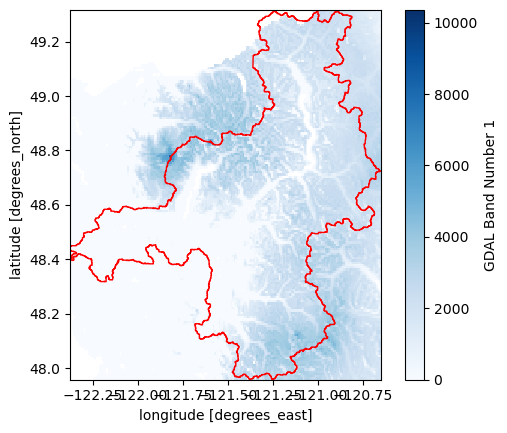

In [21]:
import matplotlib.pyplot as plt

#ds = ds.rio.write_crs('epsg:4326')
#ds = ds.rio.clip(sf.geometry, sf.crs, drop=True)


fig, ax = plt.subplots()
ds.Band1.plot(ax=ax, cmap='Blues')
sf.plot(facecolor='none', edgecolor='r', ax=ax)

-------------------------------

Organize with zarr

In [17]:
def dask_start_cluster(
    workers,
    threads=1,
    ip_address=None,
    port=":8786",
    open_browser=False,
    verbose=True,
):
    """
    Starts a dask cluster. Can provide a custom IP or URL to view the progress dashboard.
    This may be necessary if working on a remote machine.
    """
    cluster = LocalCluster(
        n_workers=workers,
        threads_per_worker=threads,
        #silence_logs=logging.ERROR,
        dashboard_address=port,
    )

    client = Client(cluster)

    if ip_address:
        if ip_address[-1] == "/":
            ip_address = ip_address[:-1]  # remove trailing '/' in case it exists
        port = str(cluster.dashboard_link.split(":")[-1])
        url = ":".join([ip_address, port])
        if verbose:
            print("\n" + "Dask dashboard at:", url)
    else:
        if verbose:
            print("\n" + "Dask dashboard at:", cluster.dashboard_link)
        url = cluster.dashboard_link

    if port not in url:
        if verbose:
            print("Port", port, "already occupied")

    if verbose:
        print("Workers:", workers)
        print("Threads per worker:", threads, "\n")

    if open_browser:
        webbrowser.open(url, new=0, autoraise=True)

    return client

In [18]:
input_folder = '/data0/images/SNODAS/skagit/'
zarr_output_path = '/data0/images/SNODAS/skagit/SNODAS_test.zarr'

In [22]:
client = dask_start_cluster(
    workers=6,
    threads=2,
    ip_address='http://dshydro.ce.washington.edu',
    port=":8787",
    open_browser=False,
    verbose=True,
)

/home/spestana/.conda/envs/validation/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40415 instead
  warnings.warn(



Dask dashboard at: http://dshydro.ce.washington.edu:40415/status
Workers: 6
Threads per worker: 2 



In [ ]:
## Create a Dask cluster so we can watch the dask dashboard
## If this cell is not run, how many computer cores will be used?
#workers = 6
#ip_addres = 'http://dshydro.ce.washington.edu'
#port=':8787'
#threads = 2
#cluster = LocalCluster(n_workers=workers, threads_per_worker=threads, dashboard_address=port)
#client = Client(cluster)

In [24]:
# Because the files may not be in a chronological order, we sort them so that the timeseries data we are creating will be in a chronological order.

def get_start_date_from_SNODAS_filename(s):
    datetime_str = s.split('_')[-1].split('.')[0] # format is YYYYMMDD
    datetime_object = datetime.strptime(datetime_str, '%Y%m%d')
    return datetime_object

nc_files = sorted(
    glob.glob(os.path.join(input_folder, '*.nc')),
    key=get_start_date_from_SNODAS_filename
)

In [26]:
datetimes = [get_start_date_from_SNODAS_filename(s) for s in nc_files]
files = nc_files

for i,file in enumerate(files):
    print(f"Processing {i+1} of {len(files)}...", end="\r")
    try:
        ds = xr.open_dataset(file, decode_coords="all")
        ds = ds.assign_coords({"time": datetimes[i]})
        ds = ds.expand_dims("time")
        ds = ds.reset_coords(drop=True)
        da = ds['Band1']
        new_file_name = file.replace(
            "/skagit/",
            "/skagit/withtime/",
        )
        da = da.rio.write_crs('EPSG:4326')
        da.to_netcdf(new_file_name)
    except Exception as err:
        print(f"Failed on {file}")
        print(f"Error: {err}")



KeyboardInterrupt: 

In [ ]:
nc_files = sorted(
    glob.glob(os.path.join('/data0/images/SNODAS/skagit/withtime/', '*.nc')),
    key=get_start_date_from_SNODAS_filename
)

# Open all the raster files as a single dataset (combining them together)
# Why did we choose chunks = 500? 100MB?
# https://docs.xarray.dev/en/stable/user-guide/dask.html#optimization-tips
ds = xr.open_mfdataset(nc_files, chunks={'time': 500})



In [ ]:
ds

In [ ]:
# Rename Band1 as a more indicative name: swe
ds = ds.rename({'Band1': 'swe'})



In [ ]:
ds.swe

In [ ]:
# Dask's rechunk documentation: https://docs.dask.org/en/stable/generated/dask.array.rechunk.html

# 0:-1 specifies that we want the dataset to be chunked along the 0th dimension -- the time dimension, which means that each chunk will have all 40 thousand values in time dimension
# 1:'auto', 2:'auto' and balance=True specifies that dask can freely rechunk along the latitude and longitude dimensions to attain blocks that have a uniform size
ds['swe'].data.rechunk(
    {0:-1, 1:'auto', 2:'auto'}, 
    block_size_limit=1e8, 
    balance=True
)

# Assign the dimensions of a chunk to variables to use for encoding afterwards
t,y,x = ds['swe'].data.chunks[0][0], ds['swe'].data.chunks[1][0], ds['swe'].data.chunks[2][0]



In [ ]:
ds

In [ ]:


# Create an output zarr file and write these chunks to disk
# if already exists, remove it here
shutil.rmtree(zarr_output_path, ignore_errors=False)



In [ ]:
zarr_output_path

In [ ]:
ds['swe'].encoding = {'chunks': (t, y, x)}



In [ ]:
ds.to_zarr(zarr_output_path)

In [ ]:
# Display 
source_group = zarr.open(zarr_output_path)
source_array = source_group['swe']
print(source_group.tree())
print(source_array.info)
del source_group
del source_array